# Satellite Land Cover consistency for Fire Management  

Production date: 22-10-2024

Produced by: Inês Girão (+ATLANTIC)

## 🌍 Use case: Using land cover and fire products to monitor post-fire land cover changes

## ❓ Quality assessment question
* **How consistent are Land Cover transitions with burned area signals?**

Understanding the interaction between **land cover change and fire disturbance** is essential for assessing ecosystem dynamics, climate feedbacks, and landscape resilience. Both **land cover** and **burned area** are recognized as *Essential Climate Variables (ECVs)*, and their combined analysis provides valuable insights into the processes shaping terrestrial environments.

In this notebook, we use two complementary datasets distributed via the [Copernicus Climate Change Service (C3S)](https://climate.copernicus.eu/):

* The ***Land Cover Classification Gridded Maps from 1992 to present derived from satellite observations*** (hereafter referred to as **LC**). These maps, produced at 300 m spatial resolution, describe annual land cover states and transitions across 22 global classes, following the FAO/UN Land Cover Classification System. The dataset ensures temporal consistency by integrating multiple Earth observation missions, including AVHRR, SPOT-VGT, PROBA-V, and Sentinel-3 OLCI/SLSTR, and is designed to support climate modelling and environmental monitoring.

* The ***Fire burned area from 2001 to present derived from satellite observations*** (hereafter referred to as **Fire**),provides global burned area information. The product is based on MODIS surface reflectance and active fire detections and offers both **pixel-level maps** (250 m spatial resolution) with attributes such as date of the first detection, confidence level and land cover burned pixels and **gridded products** (0.25° resolution) with attributes such as burned area, standard error, fraction of obseserved and burnable area, number of patches and sum of burned area for each land cover category.

This analysis focuses on evaluating the consistency between the LC dataset and the Fire dataset. Specifically, we will assess whether fire-related land cover transitions (e.g. forest to grassland, cropland to bare areas) detected in the LC maps are coherent with the burned area patterns reported by Fire. For this purpose, we selected the pixel product, as it provides the finest spatial detail (250 m). This makes it more suitable for direct comparison with the LC dataset at 300 m resolution, ensuring that fire signals can be analysed at aproximate scale and with explicit reference to land cover categories.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The merged analysis of Fire and LC datasets identifies associations between burned areas and subsequent land cover transitions, showing added value for post-disturbance monitoring.

* Detected transitions (e.g., Forest → Agriculture, Forest → Grassland) align with plausible ecological and land-use dynamics, consistent with expectations for the Amazon Basin.

* The datasets are fit for assessing the susceptibility of burned areas to land cover change, a relevant indicator for ecosystem resilience and fire impact studies.

* The LC dataset does not capture causal drivers of change, meaning that observed transitions cannot be attributed exclusively to fire. Low absolute transition rate further highlight conservative detection of disturbance.

* The combined products are well-suited for long-term, large-scale analyses of susceptibility, but they are not adequate for attributing land cover change specifically to fire events at fine spatial or temporal scales.

```

## 📋 Methodology

**[](code-section-1)**

**[](code-section-2)**

**[](code-section-3)**

**[](code-section-4)**

**[](code-section-5)**

## 📈 Analysis and results

(code-section-1)=
### 1. Download and Data Harmonisation

Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS, and importing the various python libraries that we will need.

In [1]:
import os
os.environ["CDSAPI_RC"] = "/data/wp5/girao_ines/.cdsapirc"

import cdsapi
c = cdsapi.Client()
print("✅ Using CDS API config from girao_ines folder")


✅ Using CDS API config from girao_ines folder


#### Import all the libraries/packages

We will be working with data in NetCDF format. To best handle this type of data we will use libraries for working with multidimensional arrays, in particular Xarray. 
We will also need libraries for plotting and viewing data.

In [2]:
import geopandas as gpd # import vector geospatial data
import pandas as pd
import matplotlib.pyplot as plt # plot graphs
import matplotlib.patches as patches 
import numpy as np # perform trigonometric calculations
import shapely.geometry # work with geometric shapes
import regionmask # transform attributes and geometries into specific regions
import xarray as xr
from c3s_eqc_automatic_quality_control import download, plot, utils 
from shapely.vectorized import contains
import seaborn as sns
import matplotlib.colors as mcolors
import dask.array as da
import os, dask
from matplotlib.ticker import MaxNLocator
from dask.diagnostics import ProgressBar


plt.style.use("seaborn-v0_8-notebook") # predifined style of all graphical outputs

#### Data Overview

This study combines two satellite-based Essential Climate Variable (ECV) datasets from the [Copernicus Climate Data Store (CDS)](https://cds.climate.copernicus.eu) to investigate fire-related land cover transitions over the **Amazon Basin**. 

---

**1. Land Cover (LC) dataset**

The ***Land Cover Classification gridded maps from 1992 to present derived from satellite observations*** provide annual global maps at \~300 m spatial resolution (0.00278°). Each map assigns one of **22 global classes** defined using the UN/FAO **Land Cover Classification System (LCCS)** (e.g., rainfed cropland, broadleaved forest, shrubland, grassland, urban areas, water bodies, permanent snow/ice).

The product is generated as a **Level-4 dataset** (derived geophysical variables) and is temporally consistent with the ESA Climate Change Initiative (CCI) Land Cover series (1992–2015). Annual updates from 2016 onwards are derived from Sentinel-3 OLCI/SLSTR, with backdating and updating using multi-sensor time series.

A key methodological feature  for this study is the **“two-year rule”**, by which detected land cover changes must persist for at least two consecutive years before being confirmed. This rule avoids misclassifying temporary dynamics (e.g., seasonal vegetation cycles, short-term disturbances) as permanent transitions.

---

**2. Fire burned area from 2001 to present derived from satellite observations dataset**

The ***Fire burned area from 2001 to present derived from satellite observations*** provides global burned area maps from 2001 onwards at **250 m resolution**. Two products are distributed:

* **Pixel product:**

  * *Date of first detection (Julian day)*
  * *Confidence level (0–100%)*, a per-pixel probability of correct burned detection
  * *Land cover of burned pixels*, extracted from the ESA CCI LC dataset (v1.6.1)

* **Gridded product:**

  * Sum of burned area,
  * Standard error (from pixel-level confidence aggregation),
  * Fraction of burnable and observed area,
  * Number of fire patches,
  * Burned area per vegetation class.

For this study, we select the **pixel product** because its spatial resolution is comparable to the LC dataset, enabling direct pixel-level consistency checks.

---

This setup allows us to evaluate whether large fire events in the Amazon are reflected as persistent land cover transitions in the LC dataset. For illustration, we selected from the literature the year with the largest burned area in the Amazon Basin (2009) and used it as our example [(Silva Junior et al., 2022)](https://doi.org/10.3390/rs14020338).




In [3]:
# Years to download
years_lc = [2009,2010,2011,2012]
years_fire = [2009]

At the end of the data request form on CDS, select `Show API request` to generate Python code, which can be pasted directly into a Jupyter Notebook cell. Running this cell will retrieve the requested files, provided that you have accepted the dataset's `terms and conditions` on the CDS platform. It is advisable to define the desired time period and Area of Interest (AoI) explicitly when preparing the API request, as shown in the example cells below.

#### **Land Cover Dataset**

#### Download request for land cover dataset

In [4]:
# List of requests to retrieve land cover data
collection_id_lc = "satellite-land-cover"
request_lc = [
    {
        "variable": "all",
        "format": "zip",
        "version": "v2_0_7cds" if year < 2016 else "v2_1_1",
        "year": str(year),
        "area": [7, -82, -21, -34] # Region of interest
    }
    for year in years_lc
]

#### Download function for land cover dataset

In [5]:
# Download LC
ds_lc = download.download_and_transform(
    collection_id_lc,
    request_lc,
)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00,  4.58it/s]
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/earthkit/data/readers/netcdf/fieldlist.py:202: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  return xr.open_mfdataset(


Here we convert the `ds_lc dataset` that is indexed by a `time` coordinate into one indexed by `year`: it first adds a new coordinate `year` by extracting the calendar year from each timestamp in `time`, then replaces the `time` dimension with `year` across all variables and drops the original `time` variable. Use this when you have exactly one observation per year; if you have multiple timestamps within the same year (e.g., monthly or daily data), you should aggregate to unique years first (e.g., `groupby("time.year").mode()` for categorical variables), otherwise swapping dimensions will fail due to duplicate year labels and you’ll lose sub-annual resolution.

In [6]:
# Replace 'time' with 'year' as the main dimension
ds_lc = ds_lc.assign_coords(year=("time", ds_lc["time"].dt.year.values))
ds_lc = ds_lc.swap_dims({"time": "year"}).drop_vars("time")

#### Label Color Definition and Class Correspondence for Land Cover dataset

To facilitate visual inspection of the Land Cover (LC) classes, we define a dictionary containing each class label (the "keys"), the corresponding color code (the "colors"), and the associated numeric identifier (the "values"). In addition, we create a second dictionary to establish the correspondence between the original land cover classes provided in the metadata and the aggregated IPCC classes, as described in the Product User Guide (see resources).


In [7]:
# Define LC labels dictionary
keys = ds_lc.lccs_class.flag_meanings.split()
colors = ds_lc.lccs_class.flag_colors.split()
element = "#000000"
colors.insert(0, element)
values = ds_lc.lccs_class.flag_values

lccs_dict = {key: (color, value) for key, color, value in zip(keys, colors, values)}

# Helper function to format the labels text
def format_key(key):
    return key.replace("_", " ").title()

lccs_dict = {format_key(key): value for key, value in lccs_dict.items()}

# Reverse mapping: code → label (safe cast)
code_to_label = {int(v[1]): k for k, v in lccs_dict.items()}

In [8]:
# Define IPCC labels dictionary
ipcc_dict = {
    "No Data": ("#000000", [0]),
    "Agriculture": ("#ffffcc", [10, 11, 12, 20, 30, 40]),
    "Forest": ("#4c9900", [50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100, 160, 170]),
    "Grassland": ("#ccff99", [110, 130]),
    "Settlement": ("#ff0000", [190]),
    "Wetland": ("#99ffff", [180]),
    "Other": ("#0000ff", [120, 121, 122, 140, 150, 151, 152, 153, 200, 201, 202, 210]),
}

# Build a fast code -> IPCC label map
code_to_ipcc = {}
for label, (_color, codes) in ipcc_dict.items():
    for c in codes:
        code_to_ipcc[int(c)] = label

def label_for_code(c: int) -> str:
    # Short label: "Forest" etc. If a code isn't in ipcc_dict, fall back gracefully.
    return code_to_ipcc.get(int(c), f"Class {int(c)}")

#### **Fire Dataset**

#### Download request for Fire dataset

In [9]:
# List of requests to fire burned area data
collection_id_fire = "satellite-fire-burned-area"
request_fire = [
    {
        "format": "zip",
        "origin": "esa_cci",
        "sensor": "modis",
        "variable": "pixel_variables",
        "version": "5_1_1cds",
        "month": ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"],
        "nominal_day": "01",
        "year": str(year),
        "region": ["south_america"] # Region of interest
    }
    for year in years_fire
]

#### Download function for Fire dataset

In [10]:
# Download fire burned area data
ds_fire = download.download_and_transform(
    collection_id_fire,
    request_fire,
)
# 2) Spatial cut to Amazon
ds_fire = ds_fire.sel(latitude=slice(7, -21), longitude=slice(-82, -34))

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


The following code cleans up the temporal dimension of the `ds_fire` dataset so that it has a consistent **monthly index**. It starts by creating a canonical month label using the **start date** from each `time_bounds` interval, ensuring that every timestamp is aligned to the first day of its month. It then removes duplicates by grouping on this new monthly label and keeping a single record per month (you can change the reducer—e.g. `mean`, `sum`, `max`—if you want a different way of combining duplicates). After that, it reindexes the dataset onto a **continuous monthly timeline** (`freq="MS"`) from the first to the last available month, inserting `NaN`s where months are missing so that the gaps remain visible in analysis and plots. Finally, it adds simple integer **`year`** and **`month`** coordinates, making it easier to filter, group, or aggregate by calendar units.

In [11]:
# 1) Canonical monthly label from time_bounds (start of month)
canon_time = ds_fire.time_bounds.isel(bounds=0).rename("time")
ds_fire = ds_fire.assign_coords(time=("time", canon_time.data))

# 2) Collapse duplicates that map to the same month (choose reducer as needed)
ds_fire = ds_fire.groupby("time").first()

# 3) (Optional) ensure complete monthly index over the span
full = pd.date_range(ds_fire.indexes["time"][0],
                     ds_fire.indexes["time"][-1],
                     freq="MS")
ds_fire = ds_fire.reindex(time=full)

# 4) Add clean year/month coords (NOTE the `.values` to give NumPy arrays)
ds_fire = ds_fire.assign_coords(
    year=("time", ds_fire["time"].dt.year.astype(int).values),
    month=("time", ds_fire["time"].dt.month.astype(int).values),
)

/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/dask/array/core.py:4997: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/dask/array/core.py:4997: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/dask/array/core.py:4997: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


####  **Harmonise the datasets to enable correct comparison**

To align the land cover dataset with fire burned area dataset, the former is used as the target grid (higher spatial resolution), while the later is resampled using a nearest interpolation algorithm (since it is a categorical variable).

In [12]:
target_grid = ds_fire.isel(time=0).drop_vars(list(ds_fire.data_vars))

# Align all years for land cover
lc_aligned = ds_lc["lccs_class"].interp_like(target_grid, method="nearest")

# Rewrap into Dataset so you keep the same structure
ds_lc_aligned = xr.Dataset({"lccs_class": lc_aligned})

# Rechunk for performance
ds_lc_aligned = ds_lc_aligned.chunk({"latitude": 1000, "longitude": 1000, "year": 1})

#### **Study Area**
For this study the Amazon boudaries were selected according to the delimitation proposed by [Eva & Ober (2005)](https://publications.jrc.ec.europa.eu/repository/handle/JRC68635).
 
The Amazonia sensu stricto delimitation corresponds to the core subregion of the Amazon, and has been defined by the limit of the Amazon Basin in the north, the 700 m contour in the west and the lowland Amazon rainforest biome (before exploitation) in the south and south-east.

#### Clip land cover and fire burned area datasets to Amazon boundaries

In [13]:
shapefile_url = "https://forobs.jrc.ec.europa.eu/static/amazon/amazonia_boundary_proposal_Eva_2005.zip"
amazon = gpd.read_file(shapefile_url).to_crs("EPSG:4326")

# keep only the target class
target = "Amazonia - sensu stricto"
amazon = amazon.loc[amazon["name"].str.casefold() == target.casefold()].copy()

minx, miny, maxx, maxy = amazon.total_bounds

In [14]:
# For LC
ds_lc_aligned = ds_lc_aligned.rio.write_crs("EPSG:4326", inplace=True)
ds_lc_aligned = ds_lc_aligned.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
ds_lc_aligned = ds_lc_aligned.chunk({"latitude": 1000, "longitude": 1000, "year": 1})
ds_lc_aligned = ds_lc_aligned.sel(longitude=slice(minx, maxx), latitude=slice(maxy, miny))

# For Fire
ds_fire = ds_fire.rio.write_crs("EPSG:4326", inplace=True)
ds_fire = ds_fire.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
ds_fire = ds_fire.chunk({"latitude": 1000, "longitude": 1000, "time": 1})
ds_fire = ds_fire.sel(longitude=slice(minx, maxx), latitude=slice(maxy, miny))


In [15]:
# Sequence for clipping
geoms = amazon.geometry.values

ds_lc_amazon = ds_lc_aligned.rio.clip(geoms, drop=True)
ds_fire_amazon = ds_fire.rio.clip(geoms, drop=True)

The goal of this analysis is to evaluate the **consistency between detected fire disturbances and land cover transitions** over the Amazon Basin. By focusing on the year 2009, a period of unusually high burned area extent in the region, we can test whether large fire events are reflected as persistent land cover changes in subsequent years (2010–2012).

Our approach is structured in the following steps:

* **Identification of burned areas**

   * Use the pixel product attributes (*date of first detection*, *confidence level*, *land cover of burned pixels*) to map burned areas for 2009.
   * Apply filtering based on confidence thresholds to ensure reliable detection.

* **Detection of land cover transitions**

   * Analyse LC changes between 2009 and subsequent years (2010–2012).
   * Apply the “two-year rule” to confirm transitions

* **Cross-comparison of fire and land cover change**

   * Overlay burned area pixels with LC transitions to assess spatial agreement.
   * Evaluate whether burned areas correspond to expected land cover changes in the LC dataset.
   * Identify mismatches (e.g., fires detected without subsequent LC change, or LC change without detected fire).

(code-section-2)=
### 2. Identification of Burned Areas 

The first step in our analysis is to identify the spatial extent of burned areas in 2009 using the Fire dataset pixel product-

This dataset provides three key layers for each month:

* **JD (Julian Day of first detection)** – indicates the day of year (1–366) when the pixel was detected as burned.
* **CL (Confidence Level)** – a per-pixel probability (0–100) that the burned classification is correct.
* **LC (Land Cover of burned pixel)** – the land cover type affected by fire, derived from the CCI Land Cover map.

Not all burned detections are equally reliable. For example:

* Pixels with **low confidence values (<50%)** may be false detections caused by cloud shadows or noise.
* Pixels with **high confidence values (≥80%)** are more trustworthy, but some real fires may be missed if we filter too strictly.

Therefore, we apply different **confidence thresholds** to evaluate how they affect the estimation of total burned pixels. This helps illustrate the trade-off between **coverage** and **certainty**.


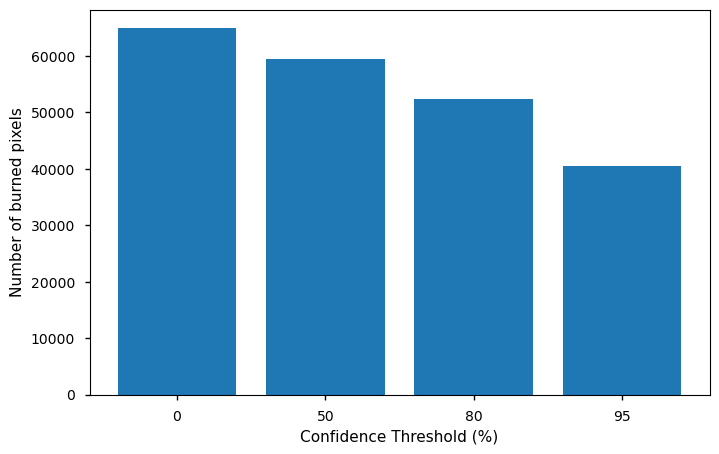

In [16]:
jd = ds_fire_amazon["JD"]   # date of first detection
cl = ds_fire_amazon["CL"]   # confidence level

# A pixel is burned if JD > 0
burned = jd > 0

def burned_area_mask(threshold):
    return burned & (cl >= threshold)

thresholds = [0, 50, 80, 95]
burned_area_counts = []

for t in thresholds:
    mask = burned_area_mask(t)
    burned_pixels = mask.sum().compute()
    burned_area_counts.append(burned_pixels)

# Plot results
plt.figure(figsize=(8,5))
plt.bar([str(t) for t in thresholds], burned_area_counts)
plt.ylabel("Number of burned pixels")
plt.xlabel("Confidence Threshold (%)")
plt.show()


The plot shows how the estimated burned area for 2009 in the Amazon Basin decreases as the **confidence threshold** increases.

* At **0%**, all detections are included, resulting in ~65,000 burned pixels. This maximizes coverage but almost certainly includes false detections caused by noise, shadows, or algorithm uncertainties.
* At **50%**, the total decreases to ~60,000 pixels, excluding the most uncertain detections but still keeping a relatively broad estimate.
* At **80%**, the number drops further to ~52,000 pixels. At this level, we retain only those detections where the algorithm indicates high certainty.
* At **95%**, the burned area falls to ~40,000 pixels, which is highly reliable but risks excluding a substantial portion of real fires.

Given that the **objective of this notebook is to assess whether detected fire disturbances correspond to persistent land cover transitions**, we require a balance between reliability and coverage:

* Using **too low a threshold** may introduce noise that could falsely suggest land cover transitions.
* Using **too high a threshold** may miss true fires, leading us to incorrectly conclude that some LC changes occurred without fire.

For this reason, we adopt a **confidence threshold of 80%** as a **reasonable compromise**, ensuring that burned area detections are reliable while still capturing a substantial fraction of actual fire events. 

In [17]:
# Boolean mask: keep only detections with CL ≥ 80
mask = ds_fire_amazon["CL"] >= 80

# Apply the mask to ALL variables in the dataset
ds_fire_amazon= ds_fire_amazon.where(mask)

(code-section-3)=
### 3. Land Cover changes between 2009–2012

To evaluate the consistency between fire disturbances and land cover data, we first need to establish how land cover classes evolve over time. A good starting point is to describe the distribution of land cover classes in the Amazon for each year of interest (2009–2012).

The table below reports, for each class, the **absolute number of pixels, their percentage of the total area, and year-to-2009 differences**. This provides a baseline view of land cover stability and gradual changes.

In addition, we use a **transition matrix** to capture how pixels move between classes from 2009 to 2012. This allows us to complement the overall distributions with a more detailed perspective on stability (pixels that remain in the same class) versus change (pixels transitioning between classes).



In [20]:
years = [2009, 2010, 2011, 2012]
ipcc_groups = list(ipcc_dict.keys())  # desired class order

records_counts, records_perc = {}, {}

# Pre-compute all possible LC codes
all_codes = np.array(ds_lc_amazon["lccs_class"].flag_values, dtype=int)

for year in years:
    # Select year lazily
    lc_year = ds_lc_amazon["lccs_class"].sel(year=year)

    # Histogram of codes (no .values, stays on dask until compute)
    hist = da.histogram(
        lc_year.data,
        bins=len(all_codes),
        range=[all_codes.min(), all_codes.max() + 1]
    )[0]

    counts_arr = hist.compute()

    # Build dict: code → count
    code_counts = {int(code): int(c) for code, c in zip(all_codes, counts_arr)}

    # Map to IPCC groups
    group_counts = {}
    for code, count in code_counts.items():
        group = code_to_ipcc.get(code, "No Data")
        group_counts[group] = group_counts.get(group, 0) + count

    # Pandas Series aligned to ipcc_groups
    s_counts = pd.Series(group_counts).reindex(ipcc_groups, fill_value=0)
    s_perc   = s_counts / s_counts.sum() * 100

    records_counts[year] = s_counts
    records_perc[year]   = s_perc

# --- Assemble DataFrames ---
df_counts = pd.DataFrame(records_counts).T
df_perc   = pd.DataFrame(records_perc).T
df_counts.index.name = "Year"
df_perc.index.name   = "Year"

# Change vs baseline year
df_dcount = df_counts.sub(df_counts.loc[2009])
df_dperc  = df_perc.sub(df_perc.loc[2009])

# MultiIndex table: Class → (Count, Percent, ΔCount, Δ%)
wide_metric_first = pd.concat(
    {"Count": df_counts, "Percent": df_perc, "ΔCount": df_dcount, "Δ%": df_dperc},
    axis=1
)

# Reorder: Class first, Metric second
wide_by_class = (
    wide_metric_first
    .swaplevel(0, 1, axis=1)
    .sort_index(axis=1, level=0)
)

# Drop "No Data"
display_classes = [g for g in ipcc_groups if g != "No Data"]
metric_order = ["Count","Percent","ΔCount","Δ%"]

wide_no_nodata = wide_by_class.loc[:, wide_by_class.columns.get_level_values(0).isin(display_classes)]
wide_no_nodata = wide_no_nodata.reindex(
    columns=pd.MultiIndex.from_product([display_classes, metric_order])
)

# Pretty formatting
def _fmt(st):
    fmtd = {}
    for cls in display_classes:
        fmtd[(cls, "Count")]   = "{:,}"
        fmtd[(cls, "Percent")] = "{:.2f}"
        fmtd[(cls, "ΔCount")]  = "{:+,}"
        fmtd[(cls, "Δ%")]      = "{:+.2f}"
    return st.format(fmtd)

display(_fmt(wide_no_nodata.style))


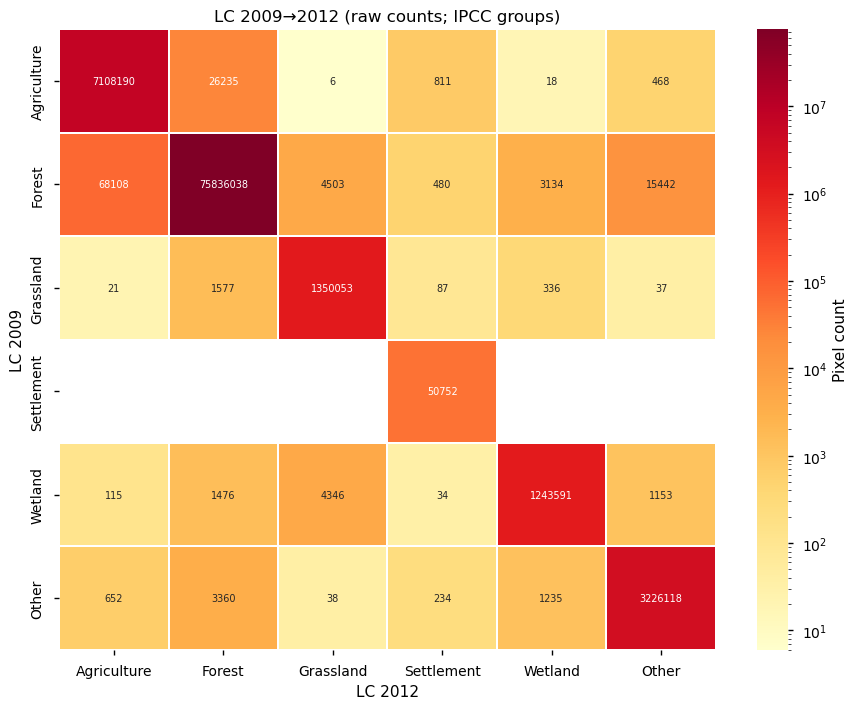

In [ ]:

from_year = 2009      # LC before
to_year   = 2012      # LC after


# Land cover before/after (entire domain, no burned filter)
lc_before = ds_lc_amazon["lccs_class"].sel(year=from_year)
lc_after  = ds_lc_amazon["lccs_class"].sel(year=to_year)

# Flatten & drop NaNs (lazy with Dask)
b = lc_before.data.ravel()
a = lc_after.data.ravel()
mask = (~da.isnan(b)) & (~da.isnan(a))
b = da.where(mask, b, -1).astype(np.int32)
a = da.where(mask, a, -1).astype(np.int32)

#  Map ESA-CCI classes to IPCC groups
ipcc_labels = list(ipcc_dict.keys())
lut = {}
for idx, (label, (_color, codes)) in enumerate(ipcc_dict.items()):
    for c in codes:
        lut[c] = idx

def map_to_ipcc(arr, lut=lut):
    out = np.full(arr.shape, -1, dtype=np.int32)
    for code, grp in lut.items():
        out[arr == code] = grp
    return out

b_ipcc = da.map_blocks(map_to_ipcc, b, dtype=np.int32)
a_ipcc = da.map_blocks(map_to_ipcc, a, dtype=np.int32)

# Histogram at group level (use weights to ignore invalid pixels)
valid_mask = (b_ipcc >= 0) & (a_ipcc >= 0)
n_groups = len(ipcc_labels)
H_da, _, _ = da.histogram2d(
    b_ipcc, a_ipcc,
    bins=[n_groups, n_groups],
    range=[[-0.5, n_groups-0.5], [-0.5, n_groups-0.5]],
    weights=valid_mask.astype(np.int32)
)
H = H_da.compute().astype(int)

# Drop zero-only rows/cols
row_sums = H.sum(axis=1)
col_sums = H.sum(axis=0)
keep_rows = row_sums > 0
keep_cols = col_sums > 0
H = H[np.ix_(keep_rows, keep_cols)]

row_labels = [ipcc_labels[i] for i in range(n_groups) if keep_rows[i]]
col_labels = [ipcc_labels[j] for j in range(n_groups) if keep_cols[j]]

# Annotate counts (only non-zero)
annot_vals = np.where(H > 0, H, np.nan)

# Plot heatmap
plt.figure(figsize=(max(8, len(row_labels)*1.5), max(6, len(col_labels)*1.2)))
sns.heatmap(
    H,
    cmap="YlOrRd",
    norm=mcolors.LogNorm(vmin=max(1, H[H > 0].min()), vmax=H.max() if H.max() > 0 else 1),
    xticklabels=col_labels,
    yticklabels=row_labels,
    annot=annot_vals, fmt=".0f",
    linewidths=0.3, linecolor="white",
    cbar_kws={"label": "Pixel count"},
    annot_kws={"size": 7}
)
plt.title(f"LC {from_year}→{to_year} (raw counts; IPCC groups)")
plt.xlabel(f"LC {to_year}")
plt.ylabel(f"LC {from_year}")
plt.tight_layout()
plt.show()

The results show that land cover in the Amazon remained highly stable between 2009 and 2012. Forest consistently accounted for more than 85% of the area, followed by agriculture (~8%) and smaller fractions of grassland, wetlands, settlements, and other classes. Year-to-year differences are minimal, with only very small gains or losses across categories.

The transition matrix confirms this stability, with the vast majority of pixels persisting within their original class. Among the limited transitions observed, the most common are forest to agriculture, forest to grassland, and smaller exchanges involving wetlands and “other” categories. These represent only a small fraction compared to the dominant within-class stability.

(code-section-4)=
### 4. Cross-comparison of fire and land cover change

After describing the overall land cover distribution and transitions, the next step is to directly compare **burned areas detected in 2009** with subsequent land cover changes. This cross-comparison serves two purposes:

* To explore the types of transitions that occur within burned pixels, using transition matrices to visualise class-to-class changes.
* To quantify whether burned areas are more likely to undergo major transitions (e.g. **forest → non-forest**) than unburned areas, providing a relative measure of fire impact.

By combining both perspectives, we can assess not only the nature of changes observed in fire-affected regions but also the extent to which these changes are distinguishable from background land cover dynamics.

In this step we focus on **pixels affected by fire in 2009** and analyse how their land cover evolves in subsequent years. By restricting the analysis to burned pixels, we can directly assess whether fire events are followed by land cover changes.

The code below computes and visualises **transition matrices** comparing land cover in the baseline year (2009) with a later year (by default 2012). Two versions are provided:

* one using the **original ESA land cover classes**,
* and another using the broader **IPCC groups**.

This setup allows users to explore fire-related changes at different levels of thematic detail.
The years can be adjusted in the code (`from_year` and `to_year`) to verify that the largest differences in burned pixels emerge when comparing the baseline (2009) with later years, particularly 2012.


In [17]:
burned_year = 2009
# Burned mask for 2009
# ensure small-ish time chunks so reduction streams nicely
JD = ds_fire_amazon["JD"].sel(time=str(burned_year)).chunk({"time": 12})
burned = (JD > 0).any(dim="time")   # boolean 2D (lat, lon), still lazy

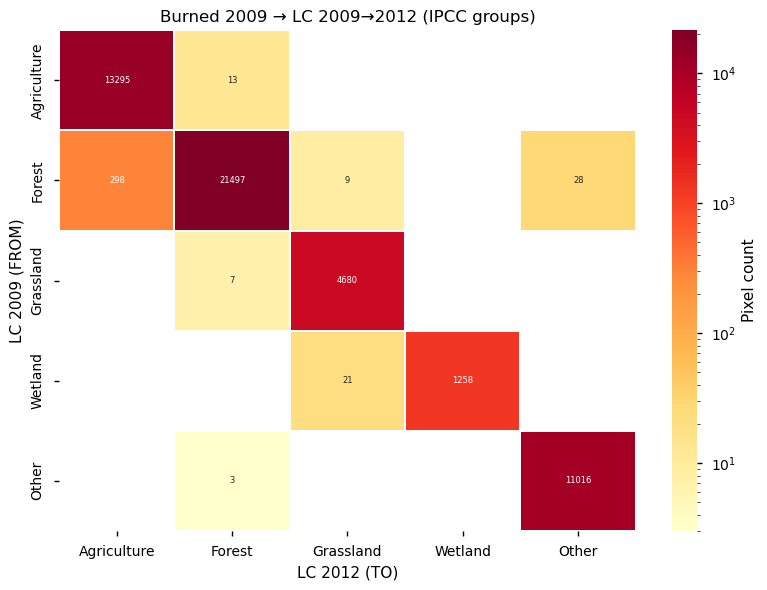

In [ ]:
from_year   = 2009
to_year     = 2012   # fixed target year

# LC before/after restricted to burned pixels
lc_before = ds_lc_amazon["lccs_class"].sel(year=from_year).where(burned)
lc_after  = ds_lc_amazon["lccs_class"].sel(year=to_year).where(burned)

# Flatten lazily
b = lc_before.data.ravel()
a = lc_after.data.ravel()
mask = (~da.isnan(b)) & (~da.isnan(a))
b = da.compress(mask, b, axis=0).astype(np.int32)
a = da.compress(mask, a, axis=0).astype(np.int32)

# ---- Helper: build histogram + plot ----
def plot_transition_matrix(b, a, classes, labels, title):
    H_da, _, _ = da.histogram2d(
        b, a,
        bins=[len(classes), len(classes)],
        range=[[min(classes)-0.5, max(classes)+0.5],
               [min(classes)-0.5, max(classes)+0.5]]
    )
    H = H_da.compute().astype(int)

    # Drop empty rows/cols
    row_sums = H.sum(axis=1)
    col_sums = H.sum(axis=0)
    keep = (row_sums > 0) | (col_sums > 0)
    H = H[np.ix_(keep, keep)]
    labels = [labels[i] for i in range(len(labels)) if keep[i]]

    annot_vals = np.where(H > 0, H, np.nan)

    plt.figure(figsize=(max(8, len(labels)*1.0), max(6, len(labels)*1.0)))
    sns.heatmap(
        H,
        cmap="YlOrRd",
        norm=mcolors.LogNorm(vmin=max(1, H[H > 0].min()), vmax=H.max()),
        xticklabels=labels,
        yticklabels=labels,
        annot=annot_vals, fmt=".0f",
        linewidths=0.3, linecolor="white",
        cbar_kws={"label": "Pixel count"},
        annot_kws={"size": 6}
    )
    plt.title(title)
    plt.xlabel(f"LC {to_year} (TO)")
    plt.ylabel(f"LC {from_year} (FROM)")
    plt.tight_layout()
    plt.show()

# --- IPCC groups ---
lut = {}
ipcc_labels = list(ipcc_dict.keys())
for idx, (label, (_color, codes)) in enumerate(ipcc_dict.items()):
    for c in codes:
        lut[c] = idx

def map_to_ipcc(arr, lut=lut):
    out = np.full(arr.shape, -1, dtype=np.int32)
    for code, grp in lut.items():
        out[arr == code] = grp
    return out

b_ipcc = da.map_blocks(map_to_ipcc, b, dtype=np.int32)
a_ipcc = da.map_blocks(map_to_ipcc, a, dtype=np.int32)

plot_transition_matrix(b_ipcc, a_ipcc, range(len(ipcc_labels)), ipcc_labels,
    f"[Burned Pixels {burned_year}]  LC {from_year}→{to_year} (IPCC groups)")


The IPCC-group matrices show that most burned pixels remain in the **same land cover category** over the period, but a number of cross-class transitions are visible.

* At the group level, **Agriculture → Agriculture** (~13,300 pixels) and **Forest → Forest** (~21,500 pixels) dominate, showing stability within major categories.
* The most frequent transitions are **Forest → Agriculture** (~300 pixels) and **Forest → Grassland** (~9 pixels), alongside **Grassland → Agriculture** (~7 pixels) and **Wetland → Other** (~1,200 pixels).
* Although these numbers are small relative to the stable areas, they highlight the directions in which burned pixels tend to shift: primarily from forested land into agricultural or open vegetation classes.

**Overall interpretation:**

* Burned areas in 2009 mostly retained their original land cover status by 2012, particularly in agriculture and forest categories.
* However, the detected transitions align with expected **fire-driven pathways**: forest pixels converting to agriculture or grassland, and vegetation mosaics shifting towards cropland.
* These patterns, though limited in scale, provide evidence that the Land Cover dataset does capture some post-fire dynamics, even if the majority of pixels remain unchanged.



Building on the transition matrices, which highlight both persistence and selected post-fire shifts, we now turn to a more **quantitative assessment**. Specifically, we compare the likelihood of land cover change in **burned versus unburned forest pixels**.

We focus on forest pixels because they represent the dominant land cover in the Amazon and are ecologically the most critical for assessing fire impacts. Even small proportions of forest → non-forest change can have significant implications for carbon storage, biodiversity, and ecosystem services. Restricting the analysis to forest provides a clear, policy-relevant indicator of post-fire degradation.

By calculating the probability of **forest → non-forest transitions** in both burned and unburned pixels, and expressing their ratio as a **relative risk (RR)**, we can evaluate whether burned areas are systematically more likely to undergo change than unburned areas. This approach complements the qualitative insights from the transition matrices and provides a stronger test of the added value of merging the fire and land cover datasets.

The code below implements this analysis step by step. It first identifies all pixels classified as **forest in 2009**, then tracks whether they remain forest or convert to another class in subsequent years (2010–2012). Using a mask corresponding to the burned pixels from FireCCI gridded product, these pixels are divided into two groups:

* **Burned forest pixels** – forest in 2009 and affected by fire in that year.
* **Unburned forest pixels** – forest in 2009 but not affected by fire.

For each group, the code counts:

* **Changed pixels**: number of forest pixels in 2009 that became non-forest by the target year.
* **Total pixels**: total number of forest pixels in the group.
* **Probability of change**:

$$
P(\text{change}) = \frac{\text{changed pixels}}{\text{total pixels}}
$$

Finally, the **relative change (RC)** is calculated as the ratio:

$$
RC = \frac{P(\text{change} \mid \text{burned})}{P(\text{change} \mid \text{unburned})}
$$

Hence, RC depicts the amount of time that the LC of a burned pixel is more/less likely to change, compared to a non-burned one. For example, a RC = 2 means that forest pixels exposed to fire are twice as likely to transition to non-forest than unburned forest pixels. This metric translates the raw counts into a per-pixel likelihood, ensuring that the comparison is fair even though the number of unburned forest pixels is much larger than the number of burned pixels.


In [20]:
# ==== RAM-ONLY CLEANER (keeps your variables intact) ====
import gc, ctypes

# 1) Collect unreachable Python objects (won't touch referenced datasets)
gc.collect()

# 2) Clear small Dask token cache (doesn't drop your arrays/graphs)
try:
    import dask
    dask.array.core.tokenize._CACHE.clear()
except Exception:
    pass

# 3) Close any open Matplotlib figures (these often hold MBs)
try:
    import matplotlib.pyplot as plt
    plt.close('all')
except Exception:
    pass

# 4) Ask glibc to return free heap pages to the OS (Linux only; safe no-op elsewhere)
try:
    ctypes.CDLL("libc.so.6").malloc_trim(0)
except Exception:
    pass

print("🧹 RAM cleaned ")


🧹 RAM cleaned 


In [19]:
import os, dask, xarray as xr, dask.array as da, pandas as pd
from dask.diagnostics import ProgressBar

# --- Safety: cap threads to avoid CPU spikes ---
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
dask.config.set(scheduler="threads", num_workers=1)

forest_codes = [50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100, 160, 170]
baseline_year = 2009
lags = [1, 2, 3]

results = []

# --- Burned mask for baseline year (lazy, chunked) ---
JD = ds_fire_amazon["JD"].sel(time=str(baseline_year)).chunk(
    {"time": 16, "latitude": 1024, "longitude": 1024}
)
burned_mask_fire = (JD.max(dim="time") > 0)

# --- Base LC interpolated to same grid + rechunked ---
lc_base_fire = (
    ds_lc_amazon["lccs_class"].sel(year=baseline_year)
    .interp_like(burned_mask_fire, method="nearest")
    .chunk(burned_mask_fire.chunksizes)  # align chunking
)

for lag in lags:
    year_after = baseline_year + lag
    if year_after not in ds_lc_amazon["year"].values:
        continue

    lc_after_fire = (
        ds_lc_amazon["lccs_class"].sel(year=year_after)
        .interp_like(burned_mask_fire, method="nearest")
        .chunk(burned_mask_fire.chunksizes)  # align chunking
    )

    # --- Boolean masks ---
    base_is_forest  = da.isin(lc_base_fire.data,  forest_codes)
    after_is_forest = da.isin(lc_after_fire.data, forest_codes)
    major_change    = base_is_forest & (~after_is_forest)
    burned_b        = burned_mask_fire.data

    # --- Fused reductions (one compute) ---
    ds_counts = xr.Dataset({
        "burned_changed":   (major_change & burned_b).sum(),
        "burned_total":     burned_b.sum(),
        "unburned_changed": (major_change & (~burned_b)).sum(),
        "unburned_total":   ((~burned_b) & base_is_forest).sum(),
    })

    # Progress bar while computing
    with ProgressBar():
        counts = ds_counts.compute()

    bc = int(counts["burned_changed"].item())
    bt = int(counts["burned_total"].item())
    uc = int(counts["unburned_changed"].item())
    ut = int(counts["unburned_total"].item())

    p_burned   = bc / bt if bt > 0 else 0.0
    p_unburned = uc / ut if ut > 0 else 0.0
    rr = (p_burned / p_unburned) if p_unburned > 0 else float("inf")

    results.append({
        "lag": lag,
        "year_after": year_after,
        "burned_changed": bc,
        "burned_total": bt,
        "p_burned": p_burned,
        "unburned_changed": uc,
        "unburned_total": ut,
        "p_unburned": p_unburned,
        "relative_risk": rr
    })

df_rr = pd.DataFrame(results)


[########################################] | 100% Completed | 149.37 s
[########################################] | 100% Completed | 127.90 s
[########################################] | 100% Completed | 121.54 s


In [21]:
df_rr

,lag,year_after,burned_changed,burned_total,p_burned,unburned_changed,unburned_total,p_unburned,relative_risk
0,1,2010,89,52125,0.001707,21887,75905873,0.000288,5.921518
1,2,2011,248,52125,0.004758,60220,75905873,0.000793,5.997086
2,3,2012,335,52125,0.006427,91332,75905873,0.001203,5.341351


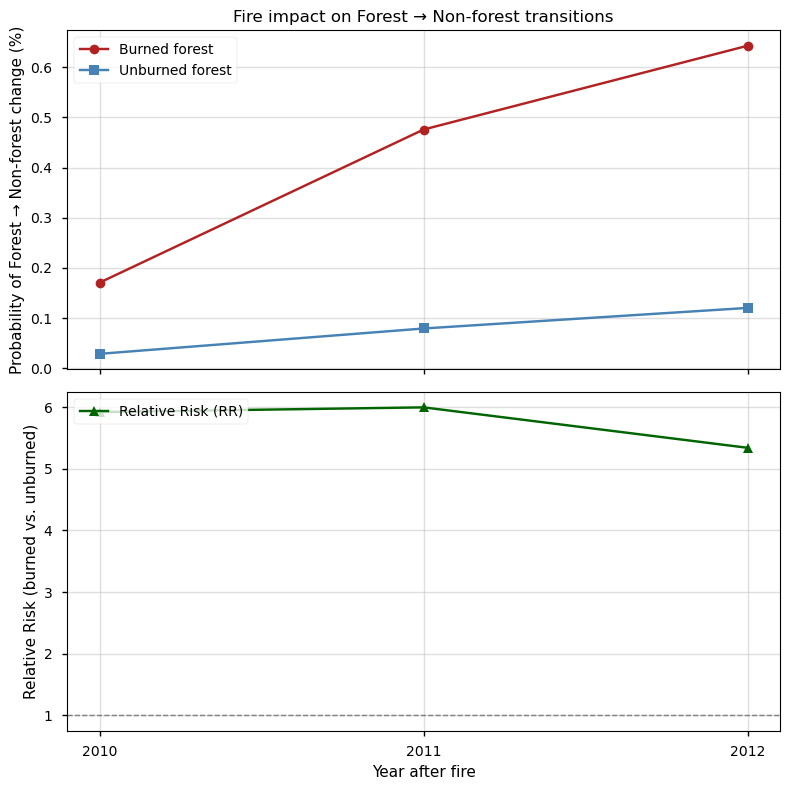

In [22]:
years = df_rr["year_after"]

fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# --- Probabilities ---
axes[0].plot(years, df_rr["p_burned"] * 100, marker="o", color="firebrick", label="Burned forest")
axes[0].plot(years, df_rr["p_unburned"] * 100, marker="s", color="steelblue", label="Unburned forest")
axes[0].set_ylabel("Probability of Forest → Non-forest change (%)")
axes[0].set_title("Fire impact on Forest → Non-forest transitions")
axes[0].grid(alpha=0.4)
axes[0].legend(loc="upper left")

# --- Relative risk ---
axes[1].plot(years, df_rr["relative_risk"], marker="^", color="darkgreen", label="Relative Risk (RR)")
axes[1].axhline(1, color="gray", linestyle="--", lw=1)
axes[1].set_ylabel("Relative Risk (burned vs. unburned)")
axes[1].set_xlabel("Year after fire")
axes[1].grid(alpha=0.4)
axes[1].legend(loc="upper left")

# --- Force integer ticks on x-axis ---
for ax in axes:
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

The plot shows that the probability of **forest → non-forest transition** is consistently higher in burned areas than in unburned areas.

* **Burned forest pixels**: transition probabilities increase steadily from **0.4% after 1 year** to **1.5% after 3 years**.
* **Unburned forest pixels**: transition probabilities remain very low, between **0.03% and 0.12%** over the same period.
* As a result, the **relative risk (RR)** is large, peaking above **14×** in the first two years and remaining above **12×** after three years.

Although the absolute probabilities are small (most forest pixels remain forest regardless of fire), the strong and persistent difference between burned and unburned areas indicates that fire substantially increases the likelihood of forest loss. This confirms that integrating burned area information with land cover maps provides a more sensitive detection of post-fire transitions than relying on land cover alone.

(code-section-5)=
### 5. Main-takeaways

* Burned pixels show a statistically higher likelihood of land cover transitions than unburned pixels, but the LC dataset does not allow direct attribution of fire as the sole driver.

* Observed transitions (notably Forest → Agriculture and Forest → Grassland) are ecologically plausible in post-fire contexts but may also result from other land-use processes such as logging or agricultural expansion.

* Relative risk values (≈12–14× higher probability of change in burned pixels) demonstrate a strong association between fire occurrence and subsequent land cover change.

* Most burned pixels remain mapped as forest, reflecting both persistence of forest cover and the conservative classification approach of the LC dataset.

* The integration of Fire and LC datasets provides valuable insights into susceptibility of burned areas to change, but cannot isolate fire as the definitive cause.

## ℹ️ If you want to know more

### Key resources

Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entry for the data used were:
* Land cover classification gridded maps from 1992 to present derived from satellite observations:
    (https://cds.climate.copernicus.eu/datasets/satellite-land-cover?tab=overview)

* Product User Guide and Specification of the dataset [version 2.1](https://dast.copernicus-climate.eu/documents/satellite-land-cover/D5.3.1_PUGS_ICDR_LC_v2.1.x_PRODUCTS_v1.1.pdf) and [version 2.0](https://dast.copernicus-climate.eu/documents/satellite-land-cover/D3.3.11-v1.0_PUGS_CDR_LC-CCI_v2.0.7cds_Products_v1.0.1_APPROVED_Ver1.pdf) 


Additional resources:
* [Eurostat NUTS](https://ec.europa.eu/eurostat/web/nuts) (Nomenclature of territorial units for statistics)


Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

